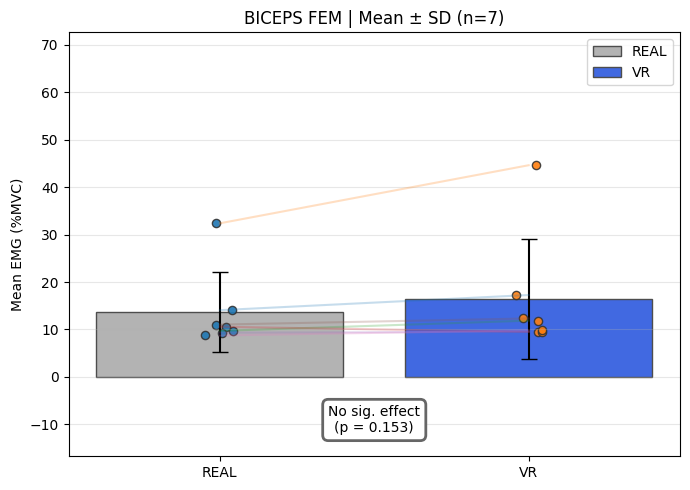

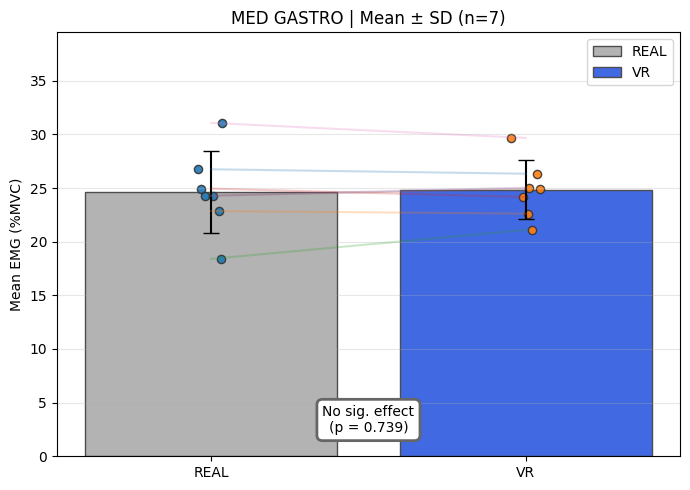

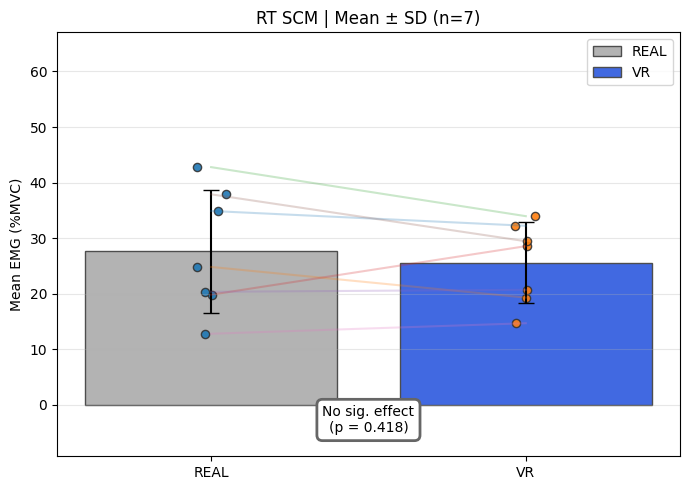

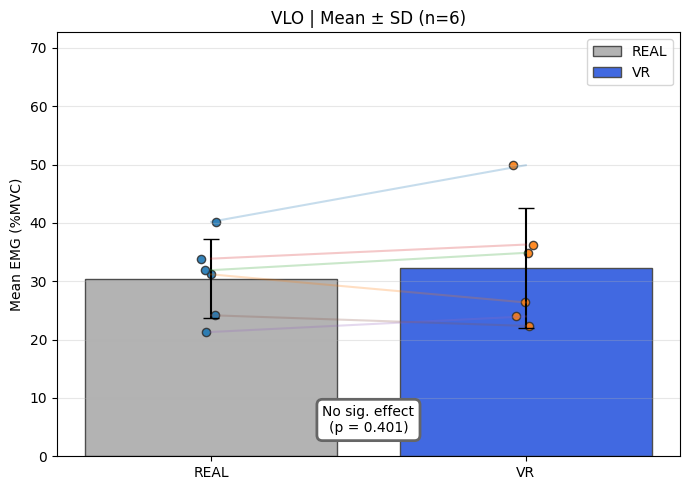

In [11]:
#%% JASP-ähnliche Tabelle + Barplot (Mean±SD) + Einzelwerte + gepaarte Linien
#   inkl. RT SCM (aus separater CSV)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# ------------------ Dateien laden ------------------
FILE_LEG = "results_tables_means_by_muscle/EMG_means_REAL_vs_VR_all_3legmuscles.csv"
FILE_SCM = "results_tables_means_by_muscle/RT_SCM_means_REAL_vs_VR_absprung_window.csv"

df_leg = pd.read_csv(FILE_LEG, sep=";")
df_scm = pd.read_csv(FILE_SCM, sep=";")

# SCM-Spalten umbenennen ins gleiche Format wie Beine (REAL_<muskel> / VR_<muskel>)
df_scm = df_scm.rename(columns={"REAL": "REAL_RT SCM", "VR": "VR_RT SCM"})

# Beide zusammenführen über Proband
df = pd.merge(df_leg, df_scm[["Proband", "REAL_RT SCM", "VR_RT SCM"]], on="Proband", how="left")

# ------------------ Paare automatisch finden: REAL_<muskel> vs VR_<muskel> ------------------
real_cols = [c for c in df.columns if c.startswith("REAL_")]
vr_cols   = [c for c in df.columns if c.startswith("VR_")]

real_map = {c.replace("REAL_", ""): c for c in real_cols}
vr_map   = {c.replace("VR_", ""): c for c in vr_cols}

muscles = sorted(set(real_map.keys()) & set(vr_map.keys()))  # gemeinsame Muskelnamen

# ------------------ Helper: Cohen's dz ------------------
def cohens_dz(diffs: np.ndarray) -> float:
    diffs = diffs[np.isfinite(diffs)]
    if diffs.size < 2:
        return np.nan
    sd = np.std(diffs, ddof=1)
    return np.mean(diffs) / sd if sd != 0 else np.nan

# ------------------ 1) Tabelle wie JASP ------------------
rows = []
for m in muscles:
    cR = real_map[m]
    cV = vr_map[m]
    sub = df[[cR, cV]].dropna()
    if len(sub) < 2:
        continue

    r = sub[cR].to_numpy(float)
    v = sub[cV].to_numpy(float)

    t, p = ttest_rel(r, v)
    dfree = len(sub) - 1
    diffs = r - v

    rows.append({
        "Measure 1": cR,
        "Measure 2": cV,
        "t": t,
        "df": dfree,
        "p": p,
        "n": len(sub),
        "mean_REAL": float(np.mean(r)),
        "mean_VR": float(np.mean(v)),
        "mean_diff (REAL-VR)": float(np.mean(diffs)),
        "SD_diff": float(np.std(diffs, ddof=1)),
        "Cohen_dz": cohens_dz(diffs),
    })

results_df = pd.DataFrame(rows)

# JASP-style Kernspalten anzeigen
jasp_like_table = results_df[["Measure 1", "Measure 2", "t", "df", "p"]].copy()
jasp_like_table

# ------------------ 2) Barplot pro Muskel: Mean±SD + Einzelwerte + gepaarte Linien + Textbox ------------------
Y_LABEL = "Mean EMG (%MVC)"  # bei SCM ist es auch %MVC (wenn du es so exportiert hast)

for m in muscles:
    cR = real_map[m]
    cV = vr_map[m]

    sub = df[[cR, cV]].dropna()
    if len(sub) < 2:
        print(f"Zu wenig Daten für {m}")
        continue

    r = sub[cR].to_numpy(float)
    v = sub[cV].to_numpy(float)

    t, p = ttest_rel(r, v)

    mean_r, sd_r = float(np.mean(r)), float(np.std(r, ddof=1))
    mean_v, sd_v = float(np.mean(v)), float(np.std(v, ddof=1))

    plt.figure(figsize=(7, 5))
    x = np.array([0, 1])

    # Bars (grau / blau wie Beispiel)
    plt.bar(x[0], mean_r, yerr=sd_r, capsize=6, color="0.7", edgecolor="0.3", label="REAL")
    plt.bar(x[1], mean_v, yerr=sd_v, capsize=6, color="royalblue", edgecolor="0.3", label="VR")

    # Einzelwerte + gepaarte Linien
    jitter = 0.05
    xr = np.full_like(r, x[0], dtype=float) + np.random.uniform(-jitter, jitter, size=r.size)
    xv = np.full_like(v, x[1], dtype=float) + np.random.uniform(-jitter, jitter, size=v.size)

    for i in range(r.size):
        plt.plot([x[0], x[1]], [r[i], v[i]], alpha=0.25)

    plt.scatter(xr, r, alpha=0.9, s=35, edgecolor="0.2")
    plt.scatter(xv, v, alpha=0.9, s=35, edgecolor="0.2")

    plt.xticks(x, ["REAL", "VR"])
    plt.ylabel(Y_LABEL)
    plt.title(f"{m} | Mean ± SD (n={len(sub)})")
    plt.grid(True, axis="y", alpha=0.3)

    # Textbox wie Beispiel
    msg = "Significant effect" if p < 0.05 else "No sig. effect"
    y_min = min(0, min(np.min(r), np.min(v)) - max(sd_r, sd_v) * 2.0)
    y_max = max(np.max(r), np.max(v)) + max(sd_r, sd_v) * 2.2
    if y_max <= y_min:
        y_max = y_min + 1

    plt.ylim(y_min, y_max)
    plt.text(
        0.5, y_min + (y_max - y_min) * 0.05,
        f"{msg}\n(p = {p:.3f})",
        ha="center", va="bottom",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="0.4", linewidth=2)
    )

    plt.legend()
    plt.tight_layout()
    plt.show()

Gefundene Parameter-Paare:
 - LT_Ankle_Max_REAL_Mean <-> LT_Ankle_Max_VR_Mean
 - LT_Hip_Max_REAL_Mean <-> LT_Hip_Max_VR_Mean
 - LT_Knee_Max_REAL_Mean <-> LT_Knee_Max_VR_Mean
 - RT_Ankle_Max_REAL_Mean <-> RT_Ankle_Max_VR_Mean
 - RT_Hip_Max_REAL_Mean <-> RT_Hip_Max_VR_Mean
 - RT_Knee_Max_REAL_Mean <-> RT_Knee_Max_VR_Mean


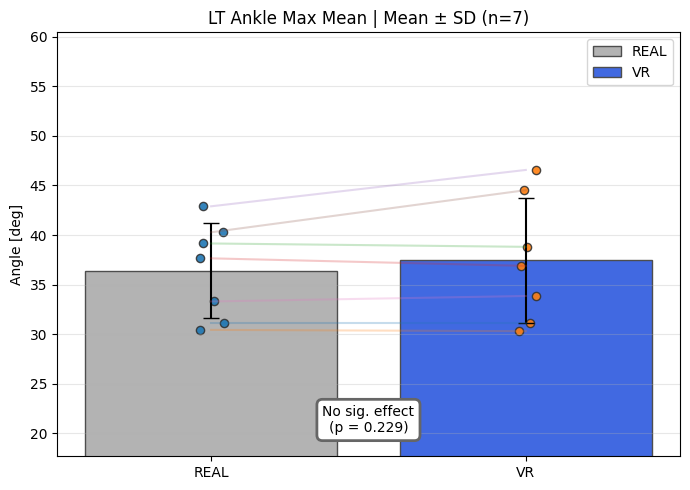

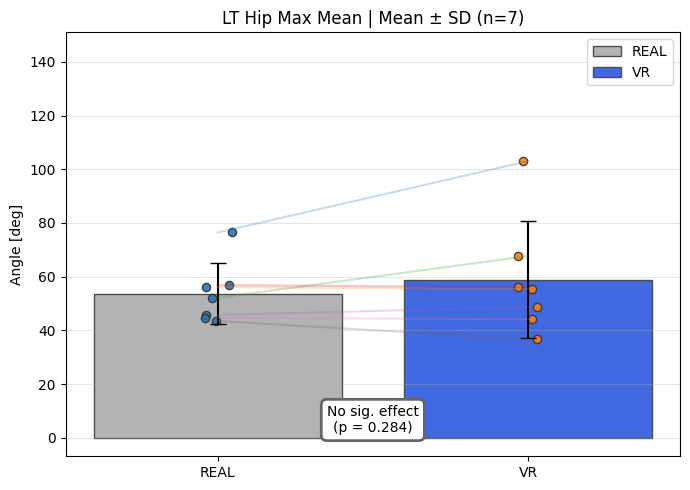

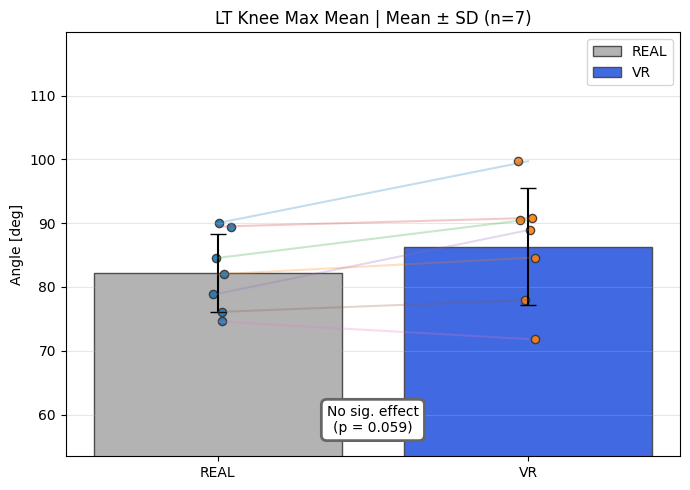

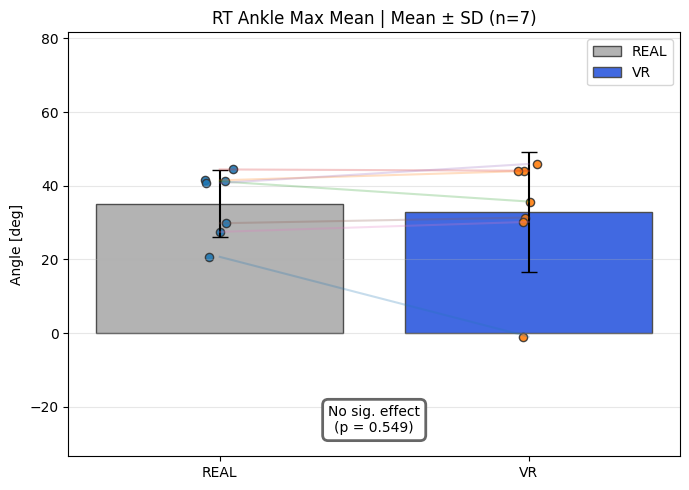

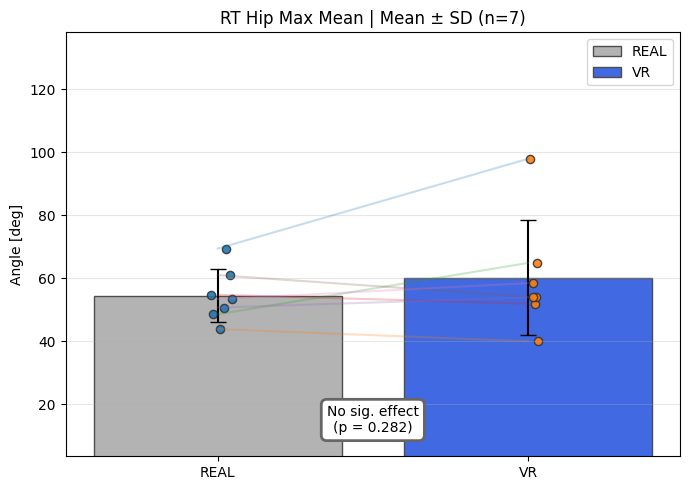

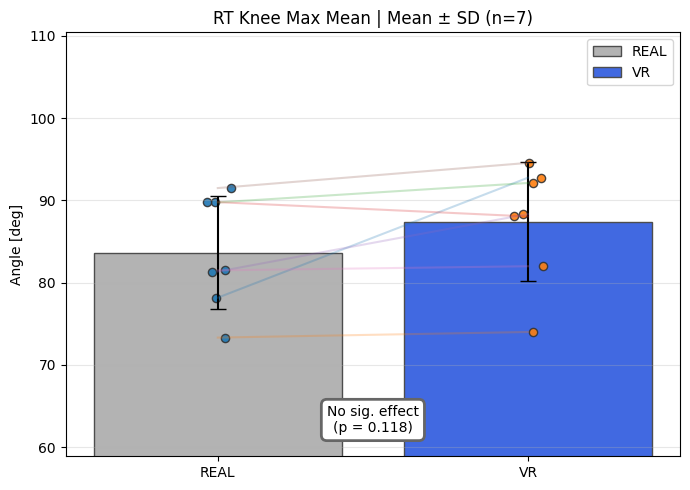

In [5]:
#%% IMU: JASP-ähnliche Tabelle + Paired t-tests (REAL vs VR) + Barplots
#   + Punkte + gepaarte Linien + automatische Y-Achsen-Beschriftung (Einheiten)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# ------------------ Datei laden ------------------
FILE = "Parameter_IMU/Master_Table_for_T-Test.csv"   # <- so wie bei dir im Projekt
# FILE = "/mnt/data/Master_Table_for_T-Test.csv"     # <- falls du aus dem Upload testen willst

df = pd.read_csv(FILE, sep=None, engine="python")

# ------------------ Y-Label Heuristik (automatisch) ------------------
def get_ylabel_from_colname(colname: str) -> str:
    c = colname.lower()

    # Winkel
    if any(k in c for k in ["angle", "deg", "knee", "hip", "ankle", "trunk", "pelvis"]):
        return "Angle [deg]"

    # Geschwindigkeit (angular velocity)
    if any(k in c for k in ["vel", "velocity", "angvel", "angularvel"]):
        return "Angular velocity [deg/s]"

    # Beschleunigung
    if any(k in c for k in ["acc", "accel", "acceleration"]):
        return "Acceleration [m/s²]"

    # Geschwindigkeit linear
    if any(k in c for k in ["speed", "v_"]):
        return "Speed [m/s]"

    # Distanz / Höhe / Weg
    if any(k in c for k in ["dist", "distance", "height", "displacement", "jump_height"]):
        return "Distance [m]"

    # Zeit
    if any(k in c for k in ["time", "duration", "ms", "sec", "s_"]):
        return "Time [s]"

    # Default
    return "Value"

def nice_title(param_base: str) -> str:
    # für Plot-Titel etwas schöner
    return param_base.replace("_", " ")

# ------------------ REAL/VR Paare automatisch finden ------------------
# Erwartetes Muster: ..._REAL_... und ..._VR_...
real_cols = [c for c in df.columns if "_REAL_" in c]
vr_cols   = [c for c in df.columns if "_VR_" in c]

real_map = {}
vr_map = {}

for c in real_cols:
    base = c.split("_REAL_")[0] + "_" + c.split("_REAL_")[1]
    real_map[base] = c

for c in vr_cols:
    base = c.split("_VR_")[0] + "_" + c.split("_VR_")[1]
    vr_map[base] = c

params = sorted(set(real_map.keys()) & set(vr_map.keys()))

print("Gefundene Parameter-Paare:")
for p in params:
    print(" -", real_map[p], "<->", vr_map[p])

# ------------------ Helper: Cohen's dz ------------------
def cohens_dz(diffs: np.ndarray) -> float:
    diffs = diffs[np.isfinite(diffs)]
    if diffs.size < 2:
        return np.nan
    sd = np.std(diffs, ddof=1)
    return np.mean(diffs) / sd if sd != 0 else np.nan

# ------------------ 1) Tabelle wie JASP ------------------
rows = []
for p in params:
    cR = real_map[p]
    cV = vr_map[p]
    sub = df[[cR, cV]].dropna()
    if len(sub) < 2:
        continue

    r = sub[cR].to_numpy(float)
    v = sub[cV].to_numpy(float)

    t, pval = ttest_rel(r, v)
    dfree = len(sub) - 1
    diffs = r - v

    rows.append({
        "Measure 1": cR,
        "Measure 2": cV,
        "t": t,
        "df": dfree,
        "p": pval,
        "n": len(sub),
        "mean_REAL": float(np.mean(r)),
        "mean_VR": float(np.mean(v)),
        "mean_diff (REAL-VR)": float(np.mean(diffs)),
        "SD_diff": float(np.std(diffs, ddof=1)),
        "Cohen_dz": cohens_dz(diffs),
    })

results_df = pd.DataFrame(rows)

# JASP-Kernspalten anzeigen
jasp_like_table = results_df[["Measure 1", "Measure 2", "t", "df", "p"]].copy()
jasp_like_table

# ------------------ 2) Plots pro Parameter ------------------
for p in params:
    cR = real_map[p]
    cV = vr_map[p]

    sub = df[[cR, cV]].dropna()
    if len(sub) < 2:
        print(f"Zu wenig Daten für {p}")
        continue

    r = sub[cR].to_numpy(float)
    v = sub[cV].to_numpy(float)

    t, pval = ttest_rel(r, v)

    mean_r, sd_r = float(np.mean(r)), float(np.std(r, ddof=1))
    mean_v, sd_v = float(np.mean(v)), float(np.std(v, ddof=1))

    ylabel = get_ylabel_from_colname(p)  # <<< automatische Einheit aus Parameternamen

    plt.figure(figsize=(7, 5))
    x = np.array([0, 1])

    # Balken
    plt.bar(x[0], mean_r, yerr=sd_r, capsize=6, color="0.7", edgecolor="0.3", label="REAL")
    plt.bar(x[1], mean_v, yerr=sd_v, capsize=6, color="royalblue", edgecolor="0.3", label="VR")

    # Punkte + gepaarte Linien
    jitter = 0.05
    xr = np.full_like(r, x[0], dtype=float) + np.random.uniform(-jitter, jitter, size=r.size)
    xv = np.full_like(v, x[1], dtype=float) + np.random.uniform(-jitter, jitter, size=v.size)

    for i in range(r.size):
        plt.plot([x[0], x[1]], [r[i], v[i]], alpha=0.25)

    plt.scatter(xr, r, alpha=0.9, s=35, edgecolor="0.2")
    plt.scatter(xv, v, alpha=0.9, s=35, edgecolor="0.2")

    plt.xticks(x, ["REAL", "VR"])
    plt.ylabel(ylabel)
    plt.title(f"{nice_title(p)} | Mean ± SD (n={len(sub)})")
    plt.grid(True, axis="y", alpha=0.3)

    # Textbox wie Beispiel
    msg = "Significant effect" if pval < 0.05 else "No sig. effect"
    y_min = min(np.min(r), np.min(v)) - max(sd_r, sd_v) * 2.0
    y_max = max(np.max(r), np.max(v)) + max(sd_r, sd_v) * 2.2
    if y_max <= y_min:
        y_max = y_min + 1

    plt.ylim(y_min, y_max)
    plt.text(
        0.5, y_min + (y_max - y_min) * 0.05,
        f"{msg}\n(p = {pval:.3f})",
        ha="center", va="bottom",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="0.4", linewidth=2)
    )

    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
#%% Add-on für dein t-test Notebook: Cohen's d (paired = dz) für ALLE Tests berechnen + in Tabelle speichern/anzeigen
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

# ------------------------------------------------------------
# Helper: Cohen's dz (paired samples)
# dz = mean(diff) / sd(diff)
# ------------------------------------------------------------
def cohens_dz(x_real: np.ndarray, x_vr: np.ndarray) -> float:
    x_real = np.asarray(x_real, dtype=float)
    x_vr   = np.asarray(x_vr, dtype=float)
    mask = np.isfinite(x_real) & np.isfinite(x_vr)
    d = x_real[mask] - x_vr[mask]
    if d.size < 2:
        return np.nan
    sd = np.std(d, ddof=1)
    return np.mean(d) / sd if sd != 0 else np.nan

# ------------------------------------------------------------
# GENERIC: funktioniert für jedes File mit REAL_* / VR_* Spalten
# (EMG-Tabellen oder IMU Master Table – solange REAL_/VR_ Paarspalten existieren)
# ------------------------------------------------------------
def paired_ttests_with_dz(df: pd.DataFrame, real_prefix="REAL_", vr_prefix="VR_") -> pd.DataFrame:
    real_cols = [c for c in df.columns if c.startswith(real_prefix)]
    vr_cols   = [c for c in df.columns if c.startswith(vr_prefix)]

    real_map = {c.replace(real_prefix, ""): c for c in real_cols}
    vr_map   = {c.replace(vr_prefix, ""): c for c in vr_cols}
    keys = sorted(set(real_map.keys()) & set(vr_map.keys()))

    out = []
    for k in keys:
        cR, cV = real_map[k], vr_map[k]
        sub = df[[cR, cV]].dropna()
        if len(sub) < 2:
            continue
        r = sub[cR].to_numpy(float)
        v = sub[cV].to_numpy(float)

        t, p = ttest_rel(r, v)
        dz = cohens_dz(r, v)

        out.append({
            "Measure 1": cR,
            "Measure 2": cV,
            "n": len(sub),
            "t": t,
            "df": len(sub) - 1,
            "p": p,
            "Cohen_dz": dz
        })

    return pd.DataFrame(out)

# ------------------------------------------------------------
# 1) EMG (Beine) – falls du das benutzt
# ------------------------------------------------------------
FILE_EMG = "results_tables_means_by_muscle/EMG_means_REAL_vs_VR_all_3legmuscles.csv"
df_emg = pd.read_csv(FILE_EMG, sep=";")
res_emg = paired_ttests_with_dz(df_emg, real_prefix="REAL_", vr_prefix="VR_")
res_emg

# ------------------------------------------------------------
# 2) RT SCM – falls du auch SCM in einer separaten Tabelle hast
# (Layout: Proband | REAL | VR)
# -> wir mappen das kurz auf REAL_/VR_ Format
# ------------------------------------------------------------
FILE_SCM = "results_tables_means_by_muscle/RT_SCM_means_REAL_vs_VR_absprung_window.csv"
df_scm = pd.read_csv(FILE_SCM, sep=";")
df_scm = df_scm.rename(columns={"REAL": "REAL_RT SCM", "VR": "VR_RT SCM"})
res_scm = paired_ttests_with_dz(df_scm, real_prefix="REAL_", vr_prefix="VR_")
res_scm

# ------------------------------------------------------------
# 3) IMU Master Table – falls du REAL/VR als "..._REAL_..." & "..._VR_..." drin hast
# -> hier brauchen wir andere Prefix-Logik: wir bauen REAL_/VR_ Spalten künstlich
# ------------------------------------------------------------
FILE_IMU = "Parameter_IMU/Master_Table_for_T-Test.csv"
df_imu = pd.read_csv(FILE_IMU, sep=None, engine="python")

# Auto-Paare: Spalten mit "_REAL_" und "_VR_"
real_cols = [c for c in df_imu.columns if "_REAL_" in c]
vr_cols   = [c for c in df_imu.columns if "_VR_" in c]

# Map base -> col
real_map = { (c.split("_REAL_")[0] + "_" + c.split("_REAL_")[1]) : c for c in real_cols }
vr_map   = { (c.split("_VR_")[0]   + "_" + c.split("_VR_")[1])   : c for c in vr_cols }
keys = sorted(set(real_map.keys()) & set(vr_map.keys()))

rows = []
for k in keys:
    cR = real_map[k]
    cV = vr_map[k]
    sub = df_imu[[cR, cV]].dropna()
    if len(sub) < 2:
        continue
    r = sub[cR].to_numpy(float)
    v = sub[cV].to_numpy(float)

    t, p = ttest_rel(r, v)
    dz = cohens_dz(r, v)

    rows.append({
        "Measure 1": cR,
        "Measure 2": cV,
        "n": len(sub),
        "t": t,
        "df": len(sub) - 1,
        "p": p,
        "Cohen_dz": dz
    })

res_imu = pd.DataFrame(rows)
res_imu

# ------------------------------------------------------------
# OPTIONAL: Alles zusammen in eine Tabelle (wie “Results summary”)
# ------------------------------------------------------------
res_emg["Domain"] = "EMG_legs"
res_scm["Domain"] = "EMG_SCM"
res_imu["Domain"] = "IMU"

all_results = pd.concat([res_emg, res_scm, res_imu], ignore_index=True)
all_results

,Measure 1,Measure 2,n,t,df,p,Cohen_dz,Domain
0,REAL_BICEPS FEM,VR_BICEPS FEM,7,-1.633531,6,0.153476,-0.617417,EMG_legs
1,REAL_MED GASTRO,VR_MED GASTRO,7,-0.348535,6,0.739342,-0.131734,EMG_legs
2,REAL_VLO,VR_VLO,6,-0.917946,5,0.400760,-0.374750,EMG_legs
3,REAL_RT SCM,VR_RT SCM,7,0.870408,6,0.417536,0.328983,EMG_SCM
4,LT_Ankle_Max_REAL_Mean,LT_Ankle_Max_VR_Mean,7,-1.339095,6,0.229037,-0.506130,IMU
5,LT_Hip_Max_REAL_Mean,LT_Hip_Max_VR_Mean,7,-1.175831,6,0.284201,-0.444422,IMU
6,LT_Knee_Max_REAL_Mean,LT_Knee_Max_VR_Mean,7,-2.323083,6,0.059199,-0.878043,IMU
7,RT_Ankle_Max_REAL_Mean,RT_Ankle_Max_VR_Mean,7,0.635179,6,0.548753,0.240075,IMU
8,RT_Hip_Max_REAL_Mean,RT_Hip_Max_VR_Mean,7,-1.181652,6,0.282051,-0.446623,IMU
9,RT_Knee_Max_REAL_Mean,RT_Knee_Max_VR_Mean,7,-1.822237,6,0.118253,-0.688741,IMU


EMG Paare: ['BICEPS FEM', 'MED GASTRO', 'RT SCM', 'VLO']


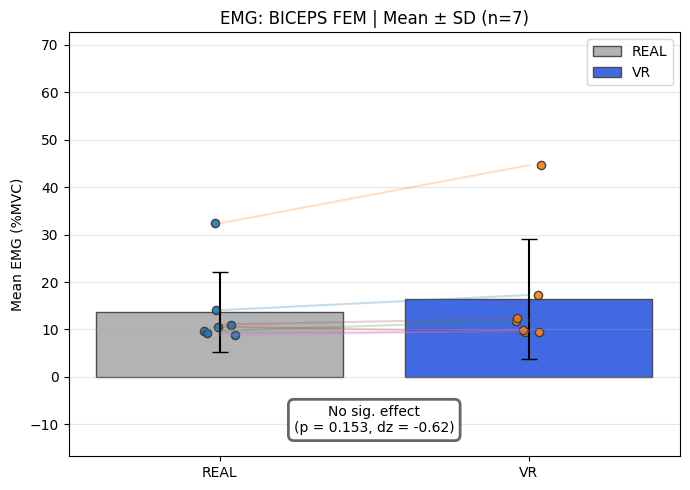

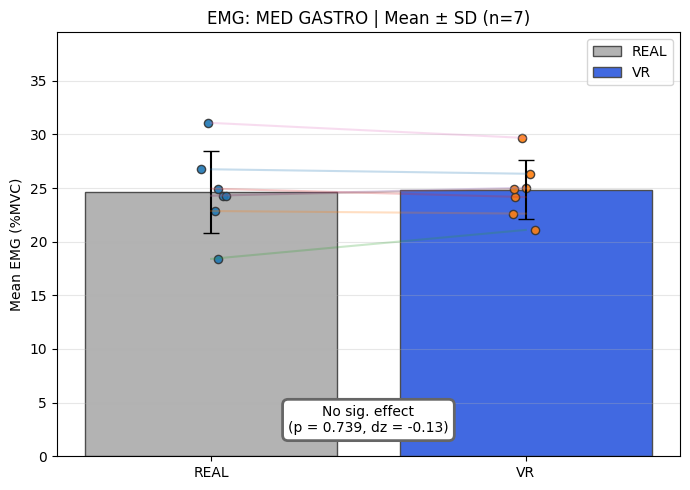

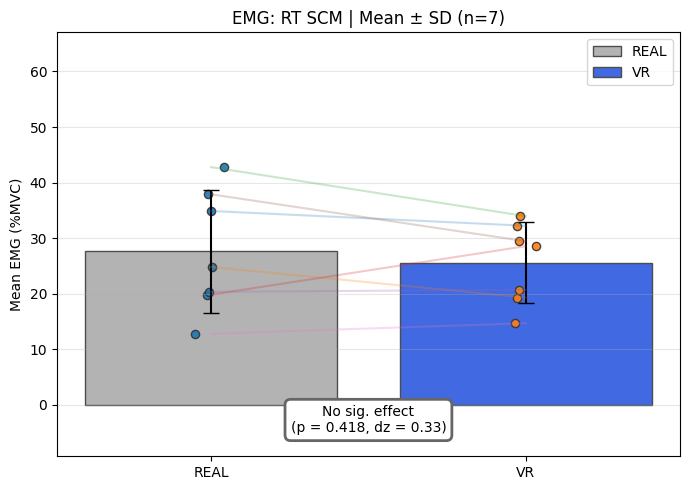

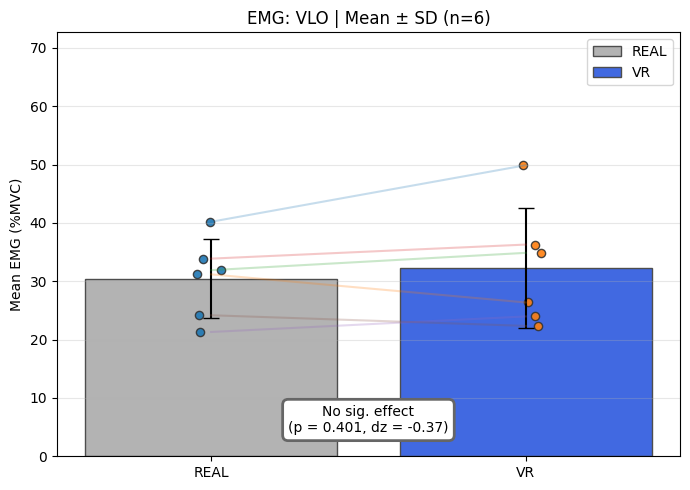

IMU Paare: ['LT_Ankle_Max_Mean', 'LT_Hip_Max_Mean', 'LT_Knee_Max_Mean', 'RT_Ankle_Max_Mean', 'RT_Hip_Max_Mean', 'RT_Knee_Max_Mean']


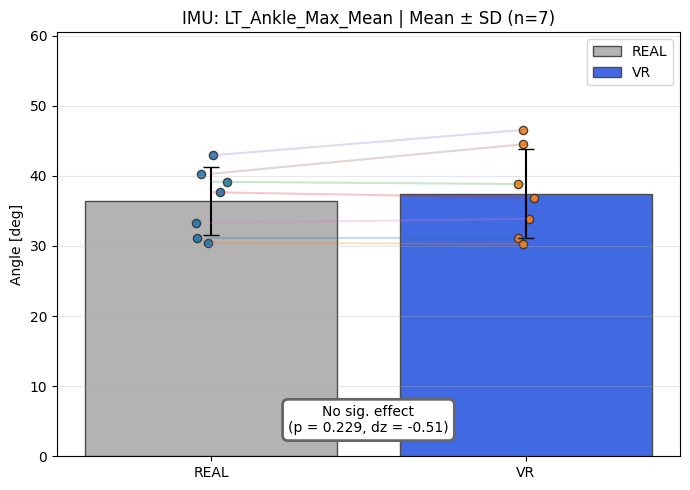

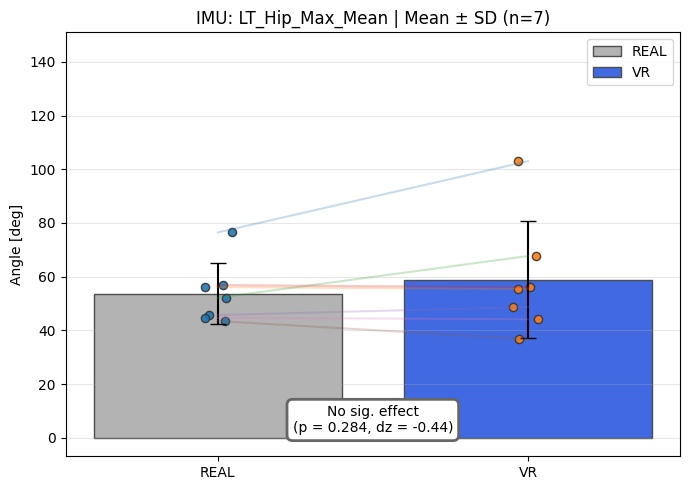

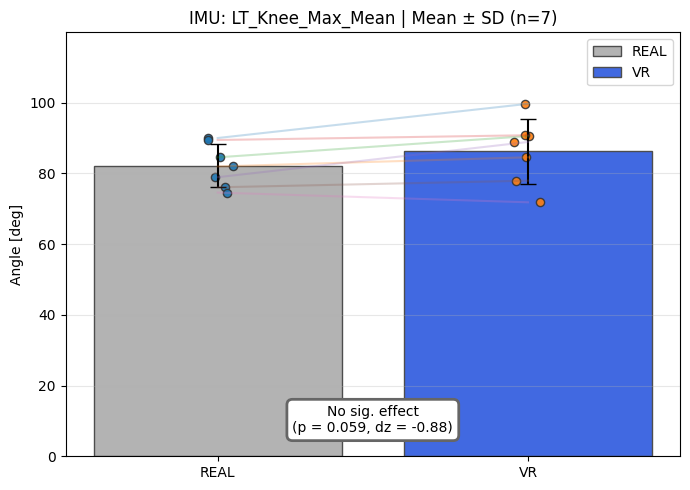

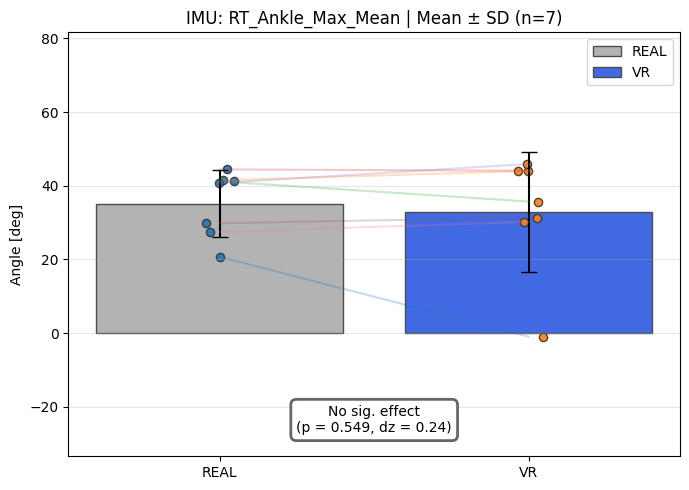

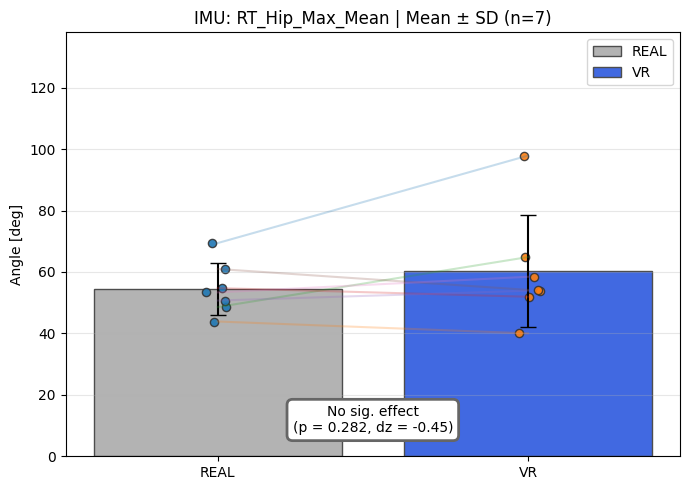

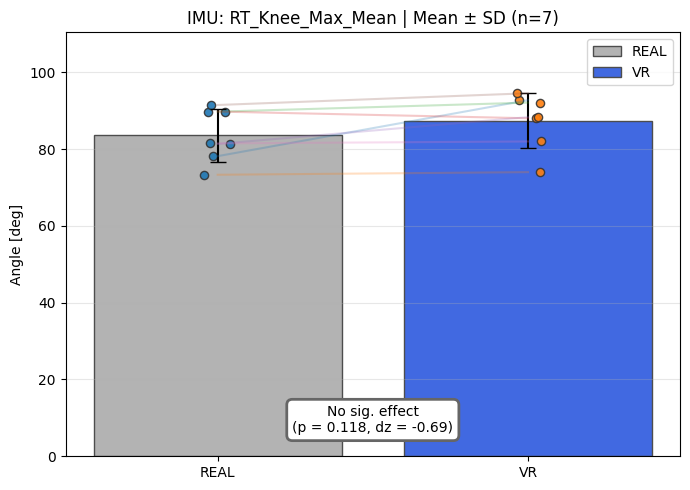

In [13]:
#%% Plots wie davor (Bars + Punkte + gepaarte Linien) – p-Wert + Cohen's dz
#   Für EMG (3 Beinmuskeln + RT SCM) UND IMU (Master_Table_for_T-Test.csv)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# ------------------ Cohen's dz (paired) ------------------
def cohens_dz(x_real: np.ndarray, x_vr: np.ndarray) -> float:
    x_real = np.asarray(x_real, dtype=float)
    x_vr   = np.asarray(x_vr, dtype=float)
    mask = np.isfinite(x_real) & np.isfinite(x_vr)
    d = x_real[mask] - x_vr[mask]           # REAL - VR
    if d.size < 2:
        return np.nan
    sd = np.std(d, ddof=1)
    return np.mean(d) / sd if sd != 0 else np.nan

# ------------------ Y-Label Heuristik (IMU) ------------------
def get_ylabel_from_colname(colname: str) -> str:
    c = colname.lower()
    if any(k in c for k in ["angle", "deg", "knee", "hip", "ankle", "trunk", "pelvis"]):
        return "Angle [deg]"
    if any(k in c for k in ["vel", "velocity", "angvel", "angularvel"]):
        return "Angular velocity [deg/s]"
    if any(k in c for k in ["acc", "accel", "acceleration"]):
        return "Acceleration [m/s²]"
    if any(k in c for k in ["speed"]):
        return "Speed [m/s]"
    if any(k in c for k in ["dist", "distance", "height", "displacement"]):
        return "Distance [m]"
    if any(k in c for k in ["time", "duration", "ms", "sec"]):
        return "Time [s]"
    return "Value"

# ------------------ Plot helper (Bar + Punkte + gepaarte Linien + Textbox) ------------------
def paired_barplot(r: np.ndarray, v: np.ndarray, title: str, y_label: str):
    r = np.asarray(r, dtype=float)
    v = np.asarray(v, dtype=float)
    mask = np.isfinite(r) & np.isfinite(v)
    r = r[mask]; v = v[mask]
    if r.size < 2:
        print(f"Zu wenig Daten für Plot: {title}")
        return

    t, p = ttest_rel(r, v)
    dz = cohens_dz(r, v)

    mean_r, sd_r = float(np.mean(r)), float(np.std(r, ddof=1))
    mean_v, sd_v = float(np.mean(v)), float(np.std(v, ddof=1))

    plt.figure(figsize=(7, 5))
    x = np.array([0, 1])

    # Bars
    plt.bar(x[0], mean_r, yerr=sd_r, capsize=6, color="0.7", edgecolor="0.3", label="REAL")
    plt.bar(x[1], mean_v, yerr=sd_v, capsize=6, color="royalblue", edgecolor="0.3", label="VR")

    # Punkte + gepaarte Linien
    jitter = 0.05
    xr = np.full_like(r, x[0], dtype=float) + np.random.uniform(-jitter, jitter, size=r.size)
    xv = np.full_like(v, x[1], dtype=float) + np.random.uniform(-jitter, jitter, size=v.size)

    for i in range(r.size):
        plt.plot([x[0], x[1]], [r[i], v[i]], alpha=0.25)

    plt.scatter(xr, r, alpha=0.9, s=35, edgecolor="0.2")
    plt.scatter(xv, v, alpha=0.9, s=35, edgecolor="0.2")

    plt.xticks(x, ["REAL", "VR"])
    plt.ylabel(y_label)
    plt.title(f"{title} | Mean ± SD (n={r.size})")
    plt.grid(True, axis="y", alpha=0.3)

    # Textbox: p + dz
    msg = "Significant effect" if p < 0.05 else "No sig. effect"
    y_min = min(0, min(np.min(r), np.min(v)) - max(sd_r, sd_v) * 2.0)
    y_max = max(np.max(r), np.max(v)) + max(sd_r, sd_v) * 2.2
    if y_max <= y_min:
        y_max = y_min + 1

    plt.ylim(y_min, y_max)
    plt.text(
        0.5, y_min + (y_max - y_min) * 0.05,
        f"{msg}\n(p = {p:.3f}, dz = {dz:.2f})",
        ha="center", va="bottom",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="0.4", linewidth=2)
    )

    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# PART A) EMG (3 Beinmuskeln + RT SCM)
# ============================================================
FILE_LEG = "results_tables_means_by_muscle/EMG_means_REAL_vs_VR_all_3legmuscles.csv"
FILE_SCM = "results_tables_means_by_muscle/RT_SCM_means_REAL_vs_VR_absprung_window.csv"

df_leg = pd.read_csv(FILE_LEG, sep=";")
df_scm = pd.read_csv(FILE_SCM, sep=";").rename(columns={"REAL": "REAL_RT SCM", "VR": "VR_RT SCM"})
df_emg = pd.merge(df_leg, df_scm[["Proband", "REAL_RT SCM", "VR_RT SCM"]], on="Proband", how="left")

# EMG Paare finden (REAL_*, VR_*)
real_cols = [c for c in df_emg.columns if c.startswith("REAL_")]
vr_cols   = [c for c in df_emg.columns if c.startswith("VR_")]
real_map = {c.replace("REAL_", ""): c for c in real_cols}
vr_map   = {c.replace("VR_", ""): c for c in vr_cols}
emg_muscles = sorted(set(real_map.keys()) & set(vr_map.keys()))

print("EMG Paare:", emg_muscles)

for m in emg_muscles:
    cR = real_map[m]
    cV = vr_map[m]
    sub = df_emg[[cR, cV]].dropna()
    paired_barplot(
        sub[cR].to_numpy(float),
        sub[cV].to_numpy(float),
        title=f"EMG: {m}",
        y_label="Mean EMG (%MVC)"
    )

# ============================================================
# PART B) IMU (Master Table)
# ============================================================
FILE_IMU = "Parameter_IMU/Master_Table_for_T-Test.csv"
df_imu = pd.read_csv(FILE_IMU, sep=None, engine="python")

# Paare über "_REAL_" / "_VR_" erkennen
imu_real_cols = [c for c in df_imu.columns if "_REAL_" in c]
imu_vr_cols   = [c for c in df_imu.columns if "_VR_" in c]

imu_real_map = { (c.split("_REAL_")[0] + "_" + c.split("_REAL_")[1]) : c for c in imu_real_cols }
imu_vr_map   = { (c.split("_VR_")[0]   + "_" + c.split("_VR_")[1])   : c for c in imu_vr_cols }
imu_params = sorted(set(imu_real_map.keys()) & set(imu_vr_map.keys()))

print("IMU Paare:", imu_params)

for p in imu_params:
    cR = imu_real_map[p]
    cV = imu_vr_map[p]
    sub = df_imu[[cR, cV]].dropna()

    paired_barplot(
        sub[cR].to_numpy(float),
        sub[cV].to_numpy(float),
        title=f"IMU: {p}",
        y_label=get_ylabel_from_colname(p)
    )

✅ Jump Height Spalten gefunden:
REAL: Jump_Height_REAL_Mean
VR:   Jump_Height_VR_Mean

Paired t-test Jump Height (n=7):
t = -1.337, df = 6, p = 0.230, Cohen's dz = -0.51


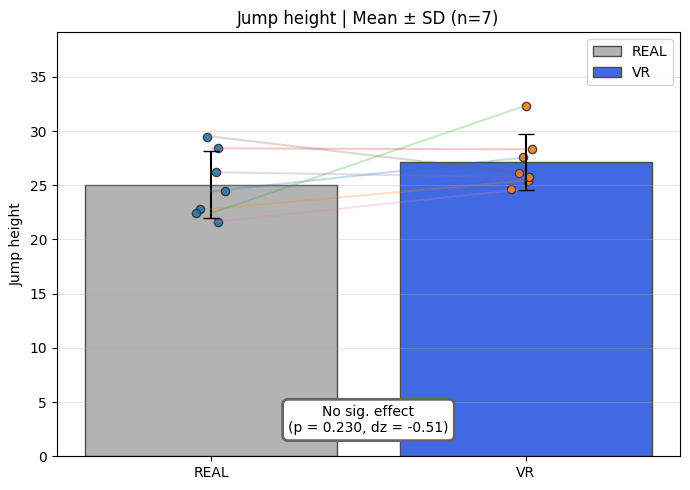

In [15]:
#%% Paired t-test + Plot NUR für Sprunghöhe (aus Master_Table_for_T-Test_Complete.csv)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

FILE = "Parameter_IMU/Master_Table_for_T-Test_Complete.csv"
# zum Testen aus Upload:
# FILE = "/mnt/data/Master_Table_for_T-Test_Complete.csv"

df = pd.read_csv(FILE, sep=None, engine="python")

# --------- Jump-Height REAL/VR Spalten automatisch finden ----------
# Erwartet ein Paar mit "_REAL_" und "_VR_" im Namen und "jump height" / "sprunghöhe" drin
def looks_like_jump_height(col: str) -> bool:
    c = col.lower()
    return (("jump" in c and "height" in c) or ("sprung" in c and ("höhe" in c or "hoehe" in c)) or ("sprungh" in c))

real_candidates = [c for c in df.columns if "_REAL_" in c and looks_like_jump_height(c)]
vr_candidates   = [c for c in df.columns if "_VR_"   in c and looks_like_jump_height(c)]

if len(real_candidates) == 0 or len(vr_candidates) == 0:
    print("❌ Konnte Jump-Height Spalten nicht automatisch finden.")
    print("REAL-Kandidaten:", real_candidates)
    print("VR-Kandidaten:", vr_candidates)
    print("\n➡️ Bitte prüfe die Spaltennamen im DataFrame:")
    print(df.columns.tolist())
else:
    # Wenn mehrere, nehmen wir das erste (meist gibt's nur eins)
    col_real = real_candidates[0]
    col_vr   = vr_candidates[0]

    # Optional: check ob beide das gleiche "Base" haben
    base_real = col_real.split("_REAL_")[0] + "_" + col_real.split("_REAL_")[1]
    base_vr   = col_vr.split("_VR_")[0]     + "_" + col_vr.split("_VR_")[1]

    print("✅ Jump Height Spalten gefunden:")
    print("REAL:", col_real)
    print("VR:  ", col_vr)

    sub = df[[col_real, col_vr]].dropna()
    r = sub[col_real].to_numpy(float)
    v = sub[col_vr].to_numpy(float)

    # --------- Stats ----------
    t, p = ttest_rel(r, v)
    diffs = r - v
    dz = np.mean(diffs) / np.std(diffs, ddof=1) if len(diffs) > 1 and np.std(diffs, ddof=1) != 0 else np.nan

    print(f"\nPaired t-test Jump Height (n={len(sub)}):")
    print(f"t = {t:.3f}, df = {len(sub)-1}, p = {p:.3f}, Cohen's dz = {dz:.2f}")

    # --------- Plot wie davor ----------
    mean_r, sd_r = float(np.mean(r)), float(np.std(r, ddof=1))
    mean_v, sd_v = float(np.mean(v)), float(np.std(v, ddof=1))

    plt.figure(figsize=(7, 5))
    x = np.array([0, 1])

    plt.bar(x[0], mean_r, yerr=sd_r, capsize=6, color="0.7", edgecolor="0.3", label="REAL")
    plt.bar(x[1], mean_v, yerr=sd_v, capsize=6, color="royalblue", edgecolor="0.3", label="VR")

    # Punkte + gepaarte Linien
    jitter = 0.05
    xr = np.full_like(r, x[0], dtype=float) + np.random.uniform(-jitter, jitter, size=r.size)
    xv = np.full_like(v, x[1], dtype=float) + np.random.uniform(-jitter, jitter, size=v.size)

    for i in range(r.size):
        plt.plot([x[0], x[1]], [r[i], v[i]], alpha=0.25)

    plt.scatter(xr, r, alpha=0.9, s=35, edgecolor="0.2")
    plt.scatter(xv, v, alpha=0.9, s=35, edgecolor="0.2")

    plt.xticks(x, ["REAL", "VR"])
    plt.ylabel("Jump height")  # wenn du Einheit kennst: z.B. "Jump height [m]" oder "[cm]"
    plt.title(f"Jump height | Mean ± SD (n={len(sub)})")
    plt.grid(True, axis="y", alpha=0.3)

    msg = "Significant effect" if p < 0.05 else "No sig. effect"
    y_min = min(0, min(np.min(r), np.min(v)) - max(sd_r, sd_v) * 2.0)
    y_max = max(np.max(r), np.max(v)) + max(sd_r, sd_v) * 2.2
    if y_max <= y_min:
        y_max = y_min + 1

    plt.ylim(y_min, y_max)
    plt.text(
        0.5, y_min + (y_max - y_min) * 0.05,
        f"{msg}\n(p = {p:.3f}, dz = {dz:.2f})",
        ha="center", va="bottom",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="0.4", linewidth=2)
    )

    plt.legend()
    plt.tight_layout()
    plt.show()